# ***Fast Fourier Transform (FFT)***

----

## ¿Qué es?
La Transformada Rápida de Fourier (FFT) es un algoritmo eficiente para calcular la Transformada de Fourier Discreta (DFT) de una secuencia de datos. Se utiliza comúnmente en una variedad de campos, incluyendo procesamiento de señales, análisis espectral y procesamiento de imágenes, para este caso se usará como filtro para la mejora en la captura de datos en tiempo real y en el postprocedado informático de una señal. Una vez establecido lo anterior se propone el estudio de la teoria detras de esta.

## Fórmula de la DFT discreta

La DFT discreta de una secuencia \( x[n] \) de longitud \( N \) se define como:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j\frac{2\pi}{N}kn}, \quad k = 0, 1, \ldots, N-1
$$

donde:
- \( X[k] \) es el componente de frecuencia en la frecuencia \( k \) (0 a \( N-1 \)).
- \( x[n] \) son los datos de entrada en el dominio del tiempo.
- \( $e^{-j\frac{2\pi}{N}kn}$ \) es la base espectral exponencial.

## Algoritmo FFT

La FFT es un algoritmo eficiente para calcular la DFT. Divide recursivamente la DFT en DFTs más pequeñas y luego combina los resultados. La FFT reduce el tiempo de cálculo de \( $O(N^2)$ \) a \( $O(N \log N)$ \), lo que hace que sea computacionalmente más práctico para secuencias largas.

## Fórmula de la FFT

La fórmula de la FFT para una secuencia de longitud \( N \) se puede escribir como:

$$
X[k] = \sum_{m=0}^{\frac{N}{2}-1} x[2m] \cdot e^{-j\frac{2\pi}{N}km} + e^{-j\frac{2\pi}{N}k} \sum_{m=0}^{\frac{N}{2}-1} x[2m+1] \cdot e^{-j\frac{2\pi}{N}km}, \quad k = 0, 1, \ldots, N-1
$$

## Aplicaciones de la FFT

- Análisis espectral de señales.
- Filtrado de señales en el dominio de la frecuencia.
- Compresión de datos.
- Procesamiento de imágenes y visión por computadora.

La FFT es una herramienta poderosa y que nos permitira conocer que armónicos en frecuencia representan ruido en nuestra toma de datos, para el caso de la MPU 6050, existiran fuentes de ruido como los movimientos involuntarios, cambios bruscos de orientación en otros.


## Caso Práctico

Se propone el uso de una base de datos de los datos ya sean adquiridos por el usuario o precargados, que nos permitan evidenciar la diferencia que existe entre una señal con tratamiento y la original, buscando una muestra que presente compatibilidad con el filtrado.

- Librerias

Se importan las librerias necesarias para el tratamiento de datos.

In [14]:
%reset

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.fft import fft, ifft, fftfreq
plt.style.use('classic')

- Obtención de datos

Se obtiene la tabla de datos que tiene las aceleraciones y las velocidades angulares pertenecientes a cada eje del acelerometro, estos fueron calculados por medio de la relación convexa entre velocidad angular capturada y tasa de cambio de angulo con respecto a las aceleraciones axiales del MPU.

In [18]:
'''
The acelerations are in m/s and the gyros in rad/s
'''
data = pd.read_csv('..\Data\slicer.csv') 
data.head(3)

,Accel x (m/s^2),Accel y (m/s^2),Accel z (m/s^2),w_x (rad/s),w_y (rad/s),w_z (rad/s),Temp (°C)
0,0.68,-2.09,8.36,0.38,0.15,0.38,25.63
1,0.76,-3.11,9.09,-0.01,0.11,-0.36,25.64
2,-0.05,-2.05,9.00,-0.05,-0.21,-0.86,25.64


- Gráficos

A continuación se observan los graficos correspondientes a la señal original sin ser filtrada.

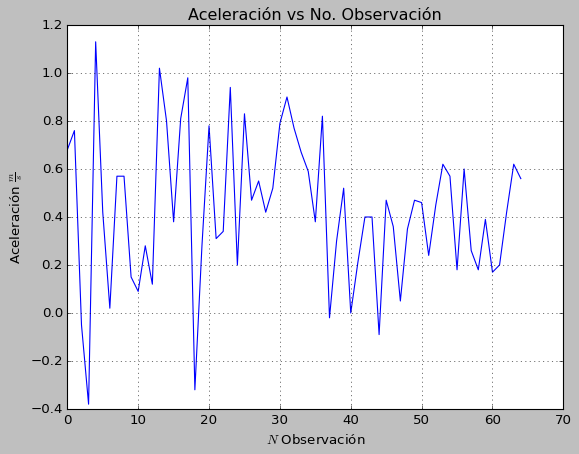

In [21]:
samples = len(data['Accel x (m/s^2)'])
total_time = 0.5*samples
v_sam = np.linspace(0,samples-1,len(data['Accel x (m/s^2)']))
data['Accel x (m/s^2)'].plot()
accx = data['Accel x (m/s^2)'].to_numpy()
plt.xlabel('$N$ Observación')
plt.ylabel(r'Aceleración $\frac{m}{s}$')
plt.title('Aceleración vs No. Observación')
plt.grid()
plt.show()

Una vez con esta pasaremos el dominio de nuestra señal a frecuencia, estableciendo cuales conjuntos de señales son caracteristicas para reconstruir nuestra señal basados en el aporte de estas, por ejemplo, para este caso estamos evaluando la aceleración en X, que pertenece a una señal de caracteristicas con valor promedio, para este caso el valor promedio de la señal o el offset pertenecera a los valores fijos con frecuencia 0, y representaran en gran medida una porción de la salida.

- Dominio de la frecuencia

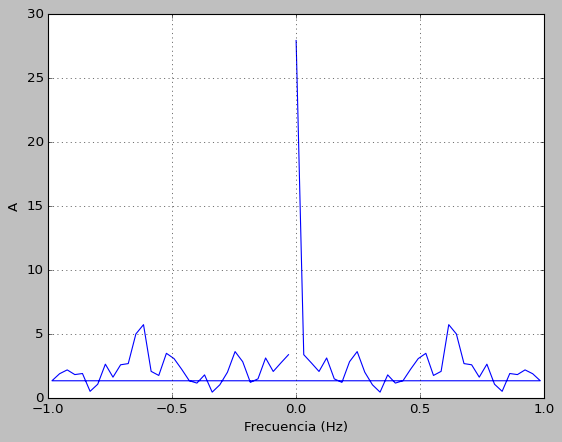

In [22]:
sample_rate = 1/0.5 # Hz 1/0.5s Tasa de muestreo de tarjeta de adquisicion 

yf = fft(accx)
n = np.arange(samples)
T = samples/samples

xf = fftfreq(samples, 1/sample_rate )
plt.plot(xf, np.abs(yf))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('A')
plt.grid()
plt.show()

A continación se realiza una función de valor efectivo de la función para analizar el error asociado de una función con respecto a la aplicación de la FFT.

In [23]:
def RMS(vector):
    sum_squared = sum(i ** 2 for i in vector)
    return sqrt(sum_squared / len(vector))

Una vez con esta calculamos la función inversa de la FFT para evaluar su valor.

In [24]:
cero_freq = np.where(xf == 0)[0][0]
print(accx.mean())
medium_value = ifft(yf)[cero_freq]
print(medium_value)

0.42969230769230765
(0.6799999999999999+5.124106267500723e-18j)


Observamos que la presencia de frecuencias cercanas a cero puede afectar el offset de la señal. Esto es especialmente relevante en señales discretizadas, donde la expresión de senos y cosenos en términos de la identidad euleriana puede generar valores complejos. Por lo tanto, es importante considerar el efecto de estas frecuencias cercanas a cero en el análisis de la señal.

- Filtro Pasa Bajas

Un filtro pasabajas es un tipo de filtro utilizado en el procesamiento de señales para atenuar o eliminar las componentes de alta frecuencia de una señal, permitiendo que pasen las componentes de baja frecuencia.  
Su funcionamiento se basa en el concepto de frecuencia de corte, que es la frecuencia a la cual el filtro comienza a atenuar las componentes de la señal. Por debajo de esta frecuencia de corte, el filtro permite que pasen las componentes de la señal prácticamente sin cambios, mientras que por encima de esta frecuencia, el filtro comienza a atenuar gradualmente las componentes de la señal. Para este caso la frecuencia seleccionada es menor a 1Hz (empezando por esta), donde podemos evidenciar el cambio de esta.

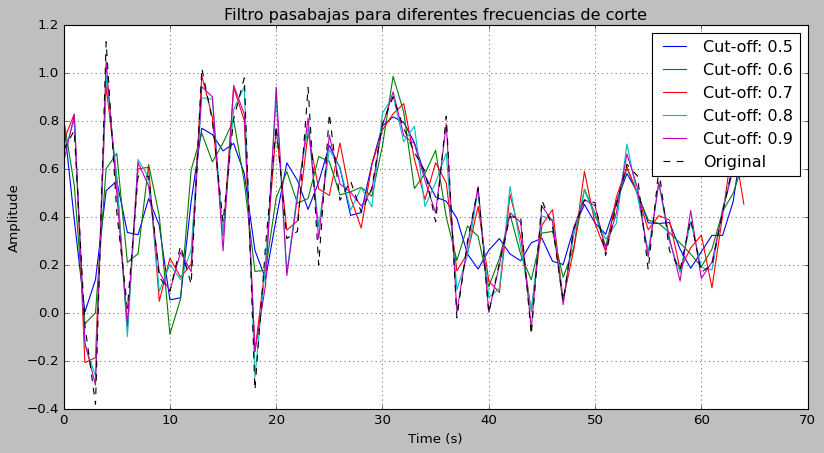

In [27]:
sig_fft_accx = yf.copy()

cut_offs = np.arange(0.5, 1, 0.1)

plt.figure(figsize=(12, 6))

for cut_off in cut_offs:
    sig_fft_accx_copy = sig_fft_accx.copy()
    
    sig_fft_accx_copy[np.abs(xf) > cut_off] = 0
    
    filtered = np.fft.ifft(sig_fft_accx_copy)
    
    plt.plot(v_sam, filtered.real, label=f'Cut-off: {cut_off:.1f}')

plt.plot(v_sam, accx, linestyle='--', color='black', label='Original')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.title('Filtro pasabajas para diferentes frecuencias de corte')
plt.show()

- Filtro Pasa Altas

Un filtro pasa altas es un tipo de filtro utilizado en el procesamiento de señales para atenuar o eliminar las componentes de baja frecuencia de una señal, permitiendo que pasen las componentes de alta frecuencia. Su funcionamiento se basa en el concepto de frecuencia de corte, que es la frecuencia a la cual el filtro comienza a atenuar las componentes de la señal. Por encima de esta frecuencia de corte, el filtro permite que pasen las componentes de la señal prácticamente sin cambios, mientras que por debajo de esta frecuencia, el filtro comienza a atenuar gradualmente las componentes de la señal. Para este caso, la frecuencia seleccionada es mayor a 1 Hz (empezando por esta), donde podemos evidenciar el cambio en la señal debido a la atenuación de las componentes de baja frecuencia.

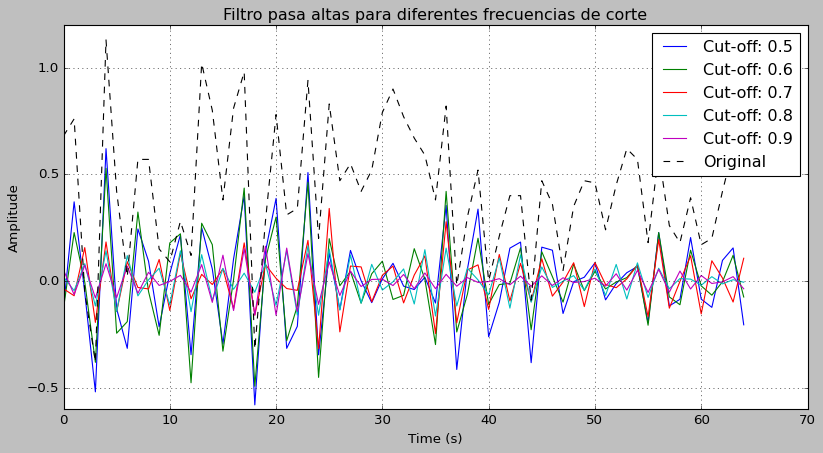

In [28]:
sig_fft_accx = yf.copy()

cut_offs = np.arange(0.5, 1, 0.1)

plt.figure(figsize=(12, 6))

for cut_off in cut_offs:
    sig_fft_accx_copy = sig_fft_accx.copy()
    
    sig_fft_accx_copy[np.abs(xf) < cut_off] = 0

    filtered = np.fft.ifft(sig_fft_accx_copy)

    plt.plot(v_sam, filtered.real, label=f'Cut-off: {cut_off:.1f}')

plt.plot(v_sam, accx, linestyle='--', color='black', label='Original')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.title('Filtro pasa altas para diferentes frecuencias de corte')
plt.show()